# [5] Ward検出モデル推論テスト

YOLOv8nモデル（160枚の実データで学習）を使用して、実際のミニマップキャプチャで推論テストを行います。

## 目的
- 実データでの検出精度確認
- Plan B（実データアノテーション）の効果検証

## モデル情報
- **バージョン**: ward_detection_v2
- **学習データ**: 100枚（80 train / 20 val）
- **検証精度**: mAP50=0.942, mAP50-95=0.741
- **クラス**: stealth_ward, stealth_ward_enemy, control_ward, control_ward_enemy

In [1]:
#cell-1: ライブラリインポート
from pathlib import Path
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

PROJECT_ROOT = Path(r"c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2")

In [4]:
#cell-2: モデル読み込み

# Plan B: 実データで学習したv2モデル
MODEL_PATH = Path(r"../models/best.pt")

if MODEL_PATH.exists():
    model = YOLO(str(MODEL_PATH))
    print(f"モデル読み込み完了: {MODEL_PATH}")
    print(f"クラス: {model.names}")
else:
    print(f"エラー: モデルが見つかりません: {MODEL_PATH}")

モデル読み込み完了: ..\models\best.pt
クラス: {0: 'stealth_ward', 1: 'stealth_ward_enemy', 2: 'control_ward', 3: 'control_ward_enemy'}


In [6]:
#cell-3: 実データパス設定

# ミニマップキャプチャ画像のディレクトリ
REAL_DATA_DIR = Path(r"C:\dataset_20260101")

# 利用可能な試合フォルダを確認
if REAL_DATA_DIR.exists():
    match_dirs = sorted(REAL_DATA_DIR.glob("JP1-*"))
    print(f"利用可能な試合: {len(match_dirs)}個")
    for d in match_dirs[:5]:  # 最初の5つを表示
        frame_count = len(list((d / "0").glob("*.png"))) if (d / "0").exists() else 0
        print(f"  {d.name}: {frame_count}フレーム")
else:
    print(f"警告: データディレクトリが見つかりません: {REAL_DATA_DIR}")

利用可能な試合: 26個
  JP1-555621265: 4255フレーム
  JP1-555639648: 1837フレーム
  JP1-555644427: 2468フレーム
  JP1-555650841: 1930フレーム
  JP1-555658734: 1889フレーム


In [7]:
#cell-4: 単一画像で推論テスト

def run_inference(image_path, conf=0.25):
    """単一画像で推論を実行"""
    results = model(str(image_path), imgsz=512, conf=conf, verbose=False)
    return results[0]

def visualize_result(result, title=""):
    """推論結果を可視化"""
    # 結果画像を取得
    result_img = result.plot()
    result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(result_img_rgb)
    plt.title(f"{title}\nDetections: {len(result.boxes)}")
    plt.axis('off')
    plt.show()
    
    # 検出結果詳細
    if len(result.boxes) > 0:
        print(f"検出数: {len(result.boxes)}")
        for i, box in enumerate(result.boxes):
            cls_id = int(box.cls[0])
            cls_name = model.names[cls_id]
            conf = float(box.conf[0])
            print(f"  {i+1}. {cls_name}: {conf:.3f}")
    else:
        print("wardは検出されませんでした")

テスト画像: C:\dataset_20260101\JP1-555621265\0\2699.png


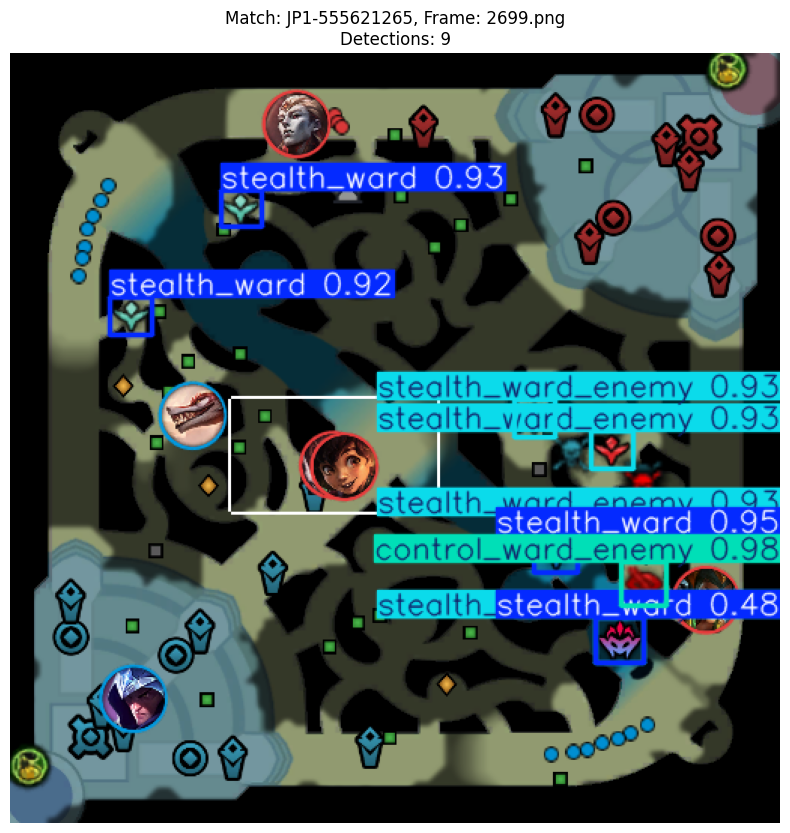

検出数: 9
  1. control_ward_enemy: 0.979
  2. stealth_ward: 0.951
  3. stealth_ward_enemy: 0.933
  4. stealth_ward_enemy: 0.932
  5. stealth_ward_enemy: 0.932
  6. stealth_ward: 0.931
  7. stealth_ward: 0.917
  8. stealth_ward: 0.483
  9. stealth_ward_enemy: 0.254


In [8]:
#cell-5: 実データでテスト（ランダムサンプル）

# 最初の試合からランダムにフレームを選択
if match_dirs:
    test_match = match_dirs[0]
    frame_dir = test_match / "0"
    
    if frame_dir.exists():
        frames = sorted(frame_dir.glob("*.png"))
        
        # ゲーム中盤のフレームを選択（wardが設置されている可能性が高い）
        mid_frames = frames[len(frames)//3 : 2*len(frames)//3]
        
        if mid_frames:
            test_frame = random.choice(mid_frames)
            print(f"テスト画像: {test_frame}")
            
            result = run_inference(test_frame, conf=0.25)
            visualize_result(result, f"Match: {test_match.name}, Frame: {test_frame.name}")

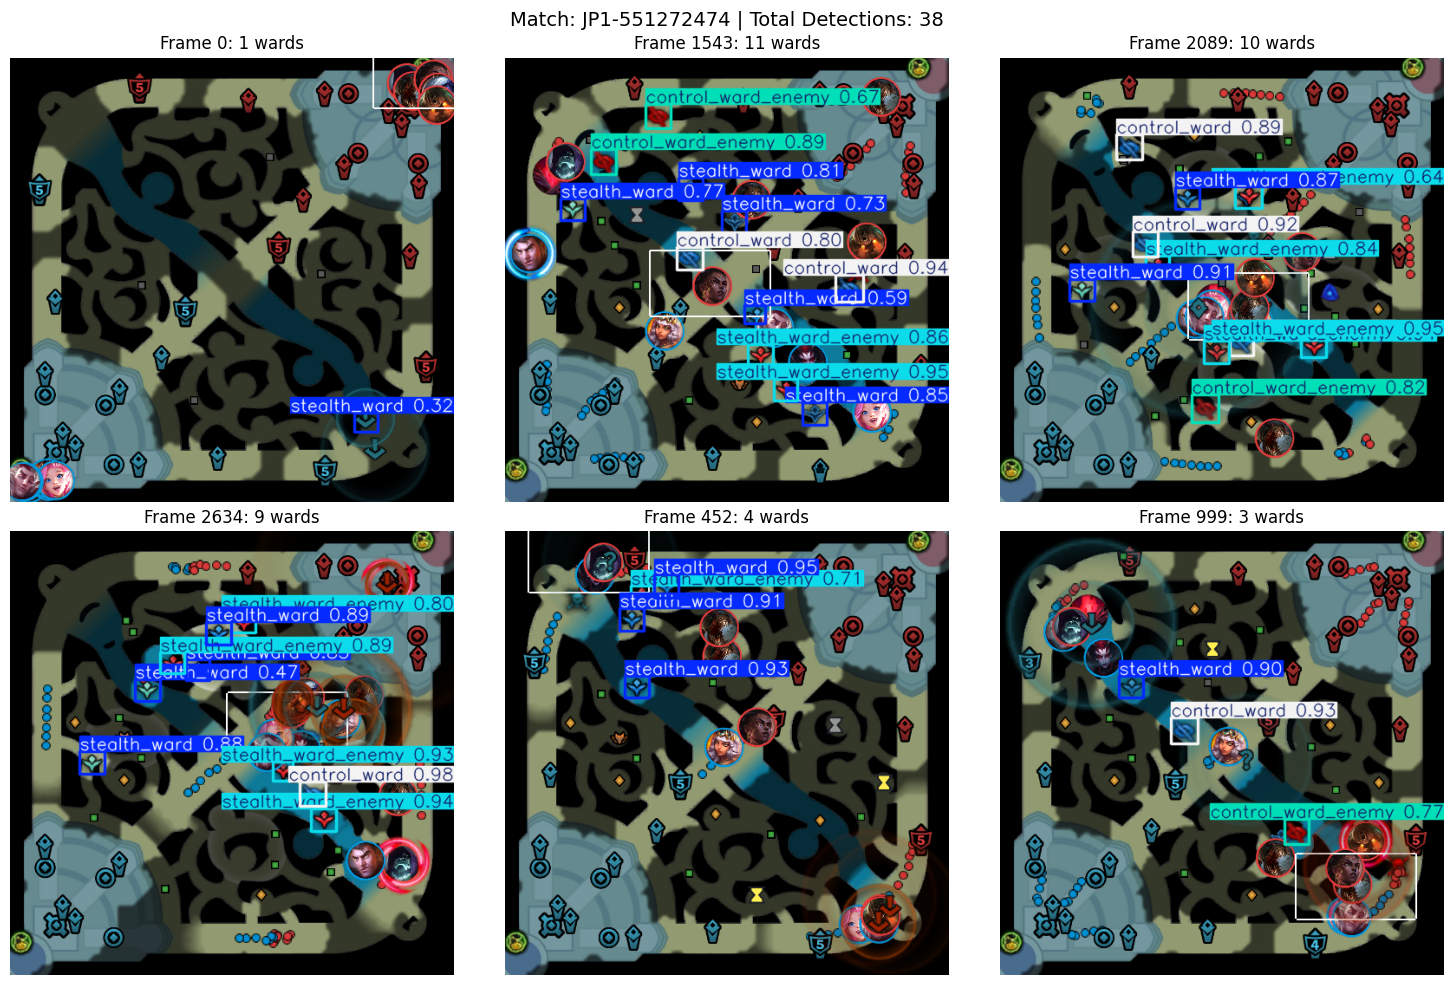

In [ ]:
#cell-6: 複数フレームで連続推論

def test_multiple_frames(match_dir, num_samples=6, conf=0.25):
    """複数フレームでテスト"""
    frame_dir = match_dir / "0"
    if not frame_dir.exists():
        print(f"フレームディレクトリが見つかりません: {frame_dir}")
        return
    
    frames = sorted(frame_dir.glob("*.png"))
    if len(frames) < num_samples:
        print(f"フレーム数が不足: {len(frames)}")
        return
    
    # 均等にサンプリング
    indices = np.linspace(0, len(frames)-1, num_samples, dtype=int)
    sample_frames = [frames[i] for i in indices]
    
    # 結果表示
    cols = 3
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    axes = axes.flatten()
    
    total_detections = 0
    for ax, frame_path in zip(axes, sample_frames):
        result = run_inference(frame_path, conf=conf)
        result_img = result.plot()
        result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        
        ax.imshow(result_img_rgb)
        ax.set_title(f"Frame {frame_path.stem}: {len(result.boxes)} wards")
        ax.axis('off')
        
        total_detections += len(result.boxes)
    
    # 余ったaxesを非表示
    for ax in axes[len(sample_frames):]:
        ax.axis('off')
    
    plt.suptitle(f"Match: {match_dir.name} | Total Detections: {total_detections}", fontsize=14)
    plt.tight_layout()
    plt.show()

# テスト実行
if match_dirs:
    test_multiple_frames(match_dirs[0], num_samples=6, conf=0.25)

テスト画像: C:\dataset\JP1-551272474\0\2361.png


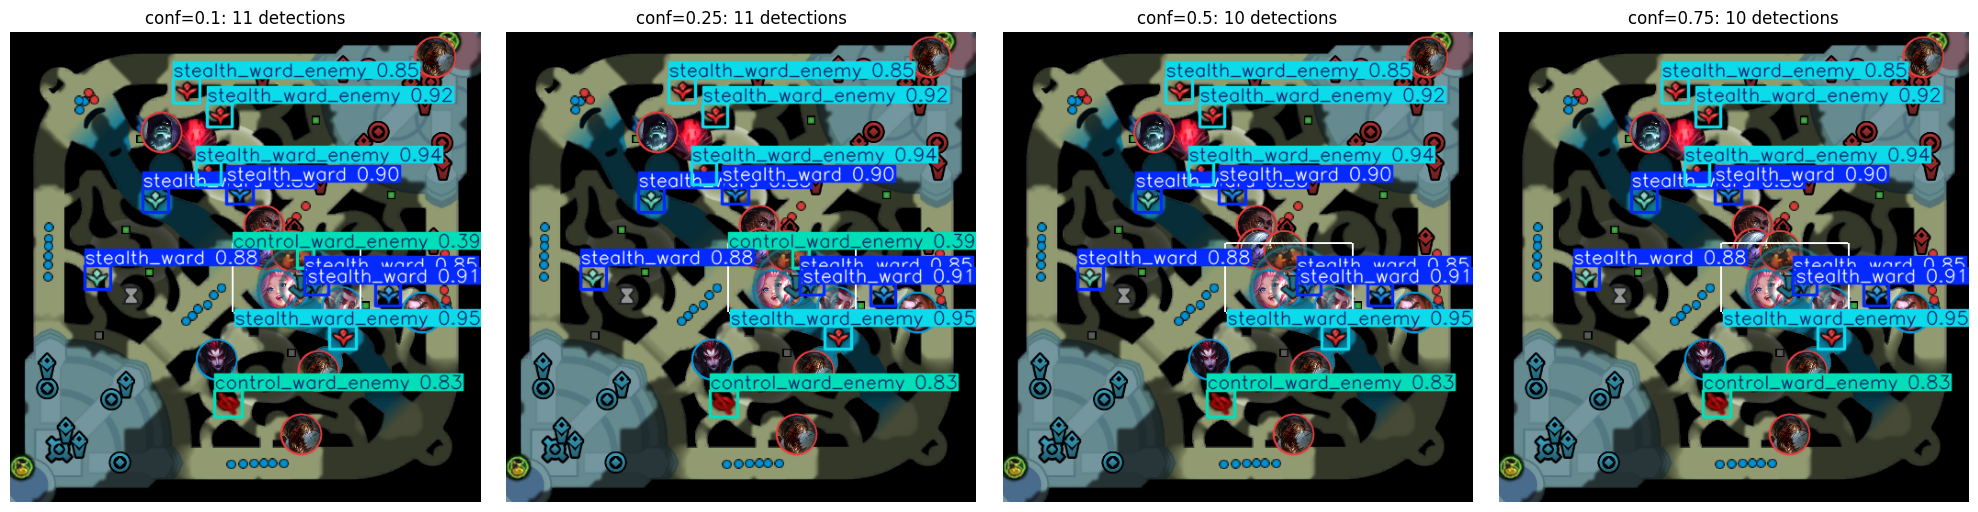

In [7]:
# cell-7: 信頼度閾値の調整テスト

def test_confidence_thresholds(image_path, thresholds=[0.1, 0.25, 0.5, 0.75]):
    """異なる信頼度閾値でテスト"""
    fig, axes = plt.subplots(1, len(thresholds), figsize=(5*len(thresholds), 5))
    
    for ax, conf in zip(axes, thresholds):
        result = run_inference(image_path, conf=conf)
        result_img = result.plot()
        result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        
        ax.imshow(result_img_rgb)
        ax.set_title(f"conf={conf}: {len(result.boxes)} detections")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# テスト実行
if match_dirs:
    frame_dir = match_dirs[0] / "0"
    frames = sorted(frame_dir.glob("*.png"))
    if frames:
        # 中盤のフレームを選択
        test_frame = frames[len(frames)//2]
        print(f"テスト画像: {test_frame}")
        test_confidence_thresholds(test_frame)

In [9]:
#cell-8: クラス別検出統計

def analyze_detections(match_dir, max_frames=100, conf=0.25):
    """クラス別の検出統計を計算"""
    frame_dir = match_dir / "0"
    if not frame_dir.exists():
        return None
    
    frames = sorted(frame_dir.glob("*.png"))[:max_frames]
    
    # クラス別カウント
    class_counts = {name: 0 for name in model.names.values()}
    total_frames = 0
    frames_with_wards = 0
    
    for frame_path in frames:
        result = run_inference(frame_path, conf=conf)
        total_frames += 1
        
        if len(result.boxes) > 0:
            frames_with_wards += 1
            for box in result.boxes:
                cls_id = int(box.cls[0])
                cls_name = model.names[cls_id]
                class_counts[cls_name] += 1
    
    return {
        'total_frames': total_frames,
        'frames_with_wards': frames_with_wards,
        'class_counts': class_counts
    }

# 統計計算
if match_dirs:
    print(f"分析中: {match_dirs[1].name}...")
    stats = analyze_detections(match_dirs[1], max_frames=100, conf=0.25)
    
    if stats:
        print(f"\n=== 検出統計 ===")
        print(f"総フレーム数: {stats['total_frames']}")
        print(f"ward検出フレーム: {stats['frames_with_wards']} ({100*stats['frames_with_wards']/stats['total_frames']:.1f}%)")
        print(f"\nクラス別検出数:")
        for cls_name, count in stats['class_counts'].items():
            print(f"  {cls_name}: {count}")

分析中: JP1-555639648...

=== 検出統計 ===
総フレーム数: 100
ward検出フレーム: 97 (97.0%)

クラス別検出数:
  stealth_ward: 22
  stealth_ward_enemy: 78
  control_ward: 234
  control_ward_enemy: 73


## 実データ検出評価

Plan Bモデル（実データ100枚で学習）の検出性能を確認します。

### 確認ポイント
1. **誤検出（False Positive）**: wardでないものをwardと誤認（チャンピオンアイコン等）
2. **見逃し（False Negative）**: 実際のwardを検出できない
3. **クラス分類精度**: 4クラス（stealth/control × 味方/敵）の正確性

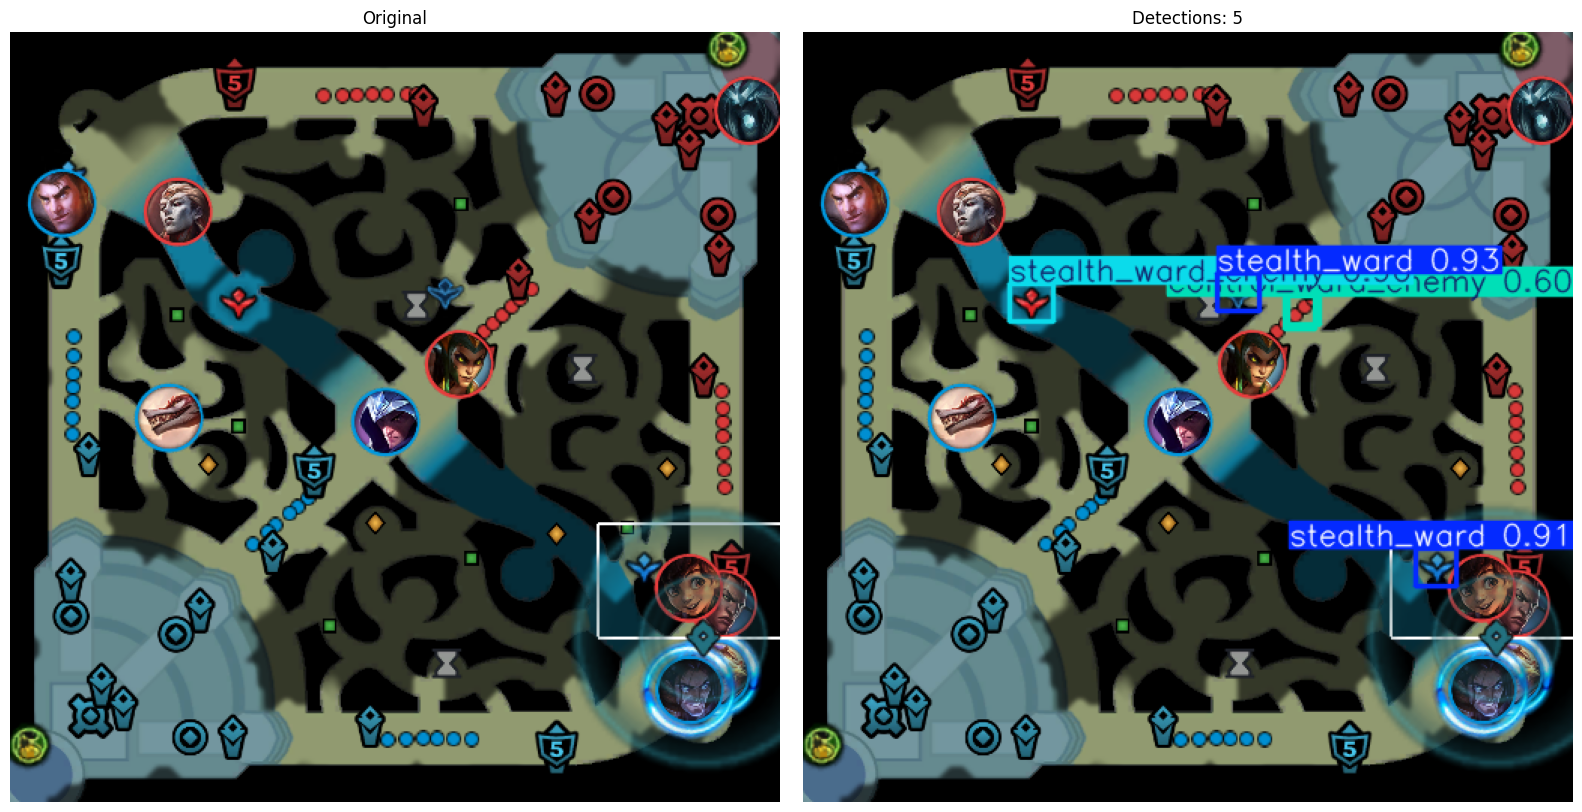


=== 検出詳細 ===
1. stealth_ward
   信頼度: 0.934
   位置: (276, 160) - (304, 186)
2. stealth_ward
   信頼度: 0.911
   位置: (408, 344) - (435, 368)
3. stealth_ward_enemy
   信頼度: 0.904
   位置: (138, 167) - (166, 192)
4. control_ward_enemy
   信頼度: 0.604
   位置: (323, 174) - (344, 195)
5. control_ward_enemy
   信頼度: 0.417
   位置: (321, 176) - (341, 198)


In [10]:
#cell-9: 手動確認用 - 特定フレームの詳細分析

def detailed_analysis(image_path, conf=0.25):
    """特定フレームの詳細分析"""
    # 元画像読み込み
    orig_img = cv2.imread(str(image_path))
    orig_img_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    # 推論
    result = run_inference(image_path, conf=conf)
    result_img = result.plot()
    result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    
    # 並べて表示
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].imshow(orig_img_rgb)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    axes[1].imshow(result_img_rgb)
    axes[1].set_title(f"Detections: {len(result.boxes)}")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 検出詳細
    print(f"\n=== 検出詳細 ===")
    if len(result.boxes) > 0:
        for i, box in enumerate(result.boxes):
            cls_id = int(box.cls[0])
            cls_name = model.names[cls_id]
            conf_val = float(box.conf[0])
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            print(f"{i+1}. {cls_name}")
            print(f"   信頼度: {conf_val:.3f}")
            print(f"   位置: ({x1:.0f}, {y1:.0f}) - ({x2:.0f}, {y2:.0f})")
    else:
        print("検出なし")

# テスト実行（フレーム番号を指定）
if match_dirs:
    frame_dir = match_dirs[0] / "0"
    # 特定のフレームを指定（例: 500番目のフレーム）
    target_frame = frame_dir / "500.png"
    if target_frame.exists():
        detailed_analysis(target_frame, conf=0.25)
    else:
        # 存在するフレームを使用
        frames = sorted(frame_dir.glob("*.png"))
        if frames:
            detailed_analysis(frames[len(frames)//2], conf=0.25)